# Data augmentation

Based on https://arxiv.org/pdf/1710.01927.pdf

In [917]:
from data_loader import load_data
import numpy as np
import matplotlib.pyplot as plt
import random
from statistics import mean

In [918]:
X, Y, groups, coord = load_data()

## CTRL augmentation

In [919]:
spectrumID = 590
spectrum = X[spectrumID]
x_axis = coord[spectrumID]

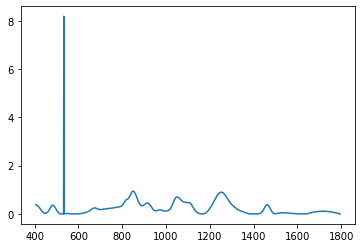

In [920]:
plt.plot(x_axis, spectrum)

In [921]:
def standard_deviation_mean(X):
    full=[]
    for i in X:
        for j in i:
            full.append(j)
    return np.std(full), mean(full)

In [922]:
stdf, meanf = standard_deviation_mean(X)

## Offset : 0,1 x Standard deviation of dataset

In [923]:
def offset_func(spectrum):
    X_offset=[]
    r=random.sample([-0.1,0.1], 1)[0]
    for i in spectrum:
        res = i+(r*stdf)
        if res > 0:
            X_offset.append(res)
        else:
            X_offset.append(0)
    return X_offset

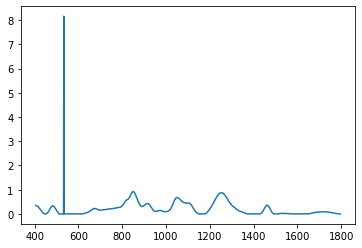

In [924]:
plt.plot(x_axis, offset_func(spectrum))

## Multiplication : 1+- 0,1 x std

In [925]:
def multiplication_func(spectrum):
    X_multiplication=[]
    r=random.uniform(0.9, 1.1)
    for i in spectrum:
        X_multiplication.append(i*r*stdf)
    return X_multiplication

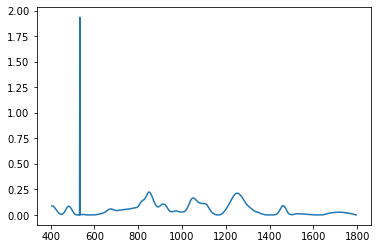

In [926]:
plt.plot(x_axis, multiplication_func(spectrum))

## Gaussian noise

In [927]:
def gaussian_noise_func(spectrum):
    noise = np.random.normal(meanf,stdf,len(spectrum))
    X_gaussian = []
    for i in range(len(spectrum)):
        res = spectrum[i]+noise[i]
        if res > 0:
            X_gaussian.append(res)
        else:
            X_gaussian.append(0)
    return X_gaussian

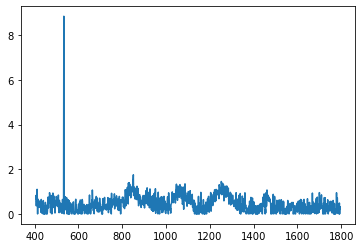

In [928]:
plt.plot(x_axis, gaussian_noise_func(spectrum))

### Sum up of all the methods visually

In [929]:
def data_augmentation(spectrum):
    return offset_func(spectrum), multiplication_func(spectrum), gaussian_noise_func(spectrum)

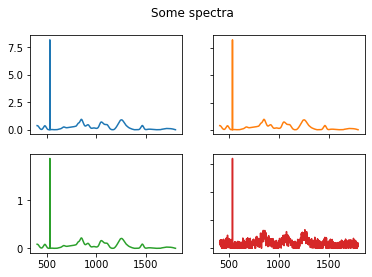

In [930]:
offset, multiplication, gaussian_noise = data_augmentation(spectrum)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(x_axis, spectrum)
ax2.plot(x_axis, offset, 'tab:orange')
ax3.plot(x_axis, multiplication, 'tab:green')
ax4.plot(x_axis, gaussian_noise, 'tab:red')

for ax in fig.get_axes():
    ax.label_outer()

## Transfer learning with data augmentation 

Here we decide to augment :
1) the ALS patients that have the lowest number of spectra

2) all the CTRL patients in order to have a more equilibrium between the 2 classes

In [931]:
def get(patient, groups):
    l= np.where(groups == patient)
    start_idx = l[0][0]
    end_idx = l[0][len(l[0])-1]
    idx_range = list(range(start_idx, end_idx+1))
    return idx_range

In [932]:
X_augmented = X
Y_augmented = Y
groups_augmented = groups

In [933]:
#Number of patient 0->29
#als -> 1 or 0
def augment(X_augmented, Y_augmented, groups_augmented, n, als):
    X_added=[]
    spectra_ind = get(n, groups_augmented)
    for spectrumID in spectra_ind:
        spectrum=X_augmented[spectrumID]
        offset, multiplication, gaussian_noise = data_augmentation(spectrum)
        inser = spectrumID
        X_added.append(offset)
        X_added.append(multiplication)
        X_added.append(gaussian_noise)
    last = spectra_ind[-1]+1
    for i in range(len(X_added)):
        X_augmented = np.insert(X_augmented, last+i, X_added[i], axis=0)
        Y_augmented = np.insert(Y_augmented, last+i, als)
        groups_augmented = np.insert(groups_augmented, last+i, n)
    return X_augmented, Y_augmented, groups_augmented

In [934]:
for i in range(15, 20):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 1)

In [935]:
for i in range(20, 30):
    X_augmented, Y_augmented, groups_augmented = augment(X_augmented, Y_augmented, groups_augmented, i, 0)

## Let's split !

In [936]:
def split_dataset(num_als, num_ctrl):
    patient_idxs_finetune = []

    x = list(range(0, 20))
    patient_idxs_finetune = random.sample(x,num_als)
    patient_idxs_test = [i for i in x if i not in patient_idxs_finetune]

    x2 = list(range(20, 30))
    patient_idxs_finetune += random.sample(x2,num_ctrl)
    patient_idxs_test += [i for i in x2 if i not in patient_idxs_finetune]

    #Shuffle to avoid implicit leakage (1 the firsts and 0 the lasts)
    random.shuffle(patient_idxs_finetune)
    random.shuffle(patient_idxs_test)
    return patient_idxs_finetune, patient_idxs_test

In [937]:
patient_idxs_finetune, patient_idxs_test = split_dataset(14,6)

In [966]:
import os,sys, time
os.chdir(os.getcwd())
models_dir = 'Bacteria_TL'
sys.path.append(models_dir)

models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']
from resnet import ResNet
import os
import torch

In [977]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1174
in_channels = 64
batch_size=10
n_classes = 2 # instead of 30, we use the 2 empiric groupings
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

In [940]:
#Remove last layers
def removekey(d, listofkeys):
    r = dict(d)
    for key in listofkeys:
        print('key: {} is removed'.format(key))
        r.pop(key)
    return r

In [964]:
def load_model(n=0):
    cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                    in_channels=in_channels, n_classes=n_classes)
    if cuda: cnn.cuda()

    checkpoint = torch.load(models_dir + '/' + models[n], map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, ['linear.weight', 'linear.bias'])
    cnn.load_state_dict(mod_weights, strict=False)
    return cnn, mod_weights, checkpoint

In [942]:
#20 patients into 4 groups of 5 patients
def group_patients(patient_idxs_finetune):
    patient_idxs = []
    x = patient_idxs_finetune
    for i in range(4):
        l = random.sample(x,5)
        patient_idxs.append(l)
        x = [i for i in x if i not in l]
    return patient_idxs

In [943]:
patient_idxs = group_patients(patient_idxs_finetune)

In [944]:
# Sample train/val/te spectra -> each group [train, train, train, val, test]
def custom_split_finetuning(patient_idxs):
    idx_tr, idx_val, idx_te = [], [], []
    for group_idx, patient_list in enumerate(patient_idxs):
        print('Group {} patients'.format(group_idx))
        print(' Tr: {}'.format(patient_list[:3]))
        print(' Val: {}'.format(patient_list[3]))
        print(' Te : {}'.format(patient_list[4]))
        for j, patient in enumerate(patient_list):
            l= np.where(groups_augmented == patient)
            start_idx = l[0][0]
            end_idx = l[0][len(l[0])-1]
            idx_range = list(range(start_idx, end_idx+1))
            np.random.shuffle(idx_range) #-> do we shuffle ? 
            print(patient, idx_range, len(idx_range))
            if j < 3:
                idx_tr.extend(idx_range)
            elif j ==3:
                idx_val.extend(idx_range)
            else:
                idx_te.extend(idx_range)
    return idx_tr, idx_val, idx_te

In [945]:
#Outputs len
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)
print(len(idx_tr))
print(len(idx_val))
print(len(idx_te))

Group 0 patients
 Tr: [14, 18, 28]
 Val: 8
 Te : 2
14 [340, 341, 336, 337, 338, 342, 335, 333, 339, 334] 10
18 [466, 496, 469, 478, 500, 494, 468, 474, 495, 501, 483, 502, 490, 463, 473, 471, 480, 488, 470, 479, 486, 465, 498, 475, 484, 489, 476, 491, 497, 487, 477, 467, 492, 472, 493, 482, 485, 481, 464, 499] 40
28 [1288, 1262, 1283, 1268, 1274, 1278, 1256, 1260, 1265, 1284, 1286, 1257, 1258, 1269, 1271, 1277, 1263, 1275, 1280, 1291, 1259, 1264, 1273, 1294, 1293, 1287, 1272, 1289, 1255, 1282, 1279, 1281, 1285, 1267, 1266, 1261, 1276, 1292, 1290, 1270] 40
8 [247, 243, 253, 242, 249, 245, 251, 254, 244, 248, 252, 241, 250, 246] 14
2 [112, 85, 79, 110, 82, 97, 86, 80, 83, 81, 99, 88, 103, 93, 102, 92, 87, 95, 104, 98, 91, 111, 101, 106, 96, 100, 108, 94, 78, 89, 113, 84, 107, 109, 90, 105] 36
Group 1 patients
 Tr: [16, 21, 1]
 Val: 29
 Te : 9
16 [403, 392, 422, 421, 396, 412, 400, 419, 389, 394, 402, 399, 393, 398, 395, 415, 401, 385, 383, 413, 417, 411, 407, 406, 416, 408, 404, 410, 409

In [969]:
from datasets import spectral_dataloader
from training import run_epoch
from torch import optim

In [975]:
# Fine-tune CNN
def finetune(cnn, idx_tr, idx_val, idx_te):
    epochs = 1
    batch_size = 10
    #t0 = time()
    # Set up Adam optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
    # Set up dataloaders
    dl_tr = spectral_dataloader(X_augmented, Y_augmented, idxs=idx_tr,
        batch_size=batch_size, shuffle=True)
    dl_val = spectral_dataloader(X_augmented, Y_augmented, idxs=idx_val,
        batch_size=batch_size, shuffle=False)
    dl_te = spectral_dataloader(X_augmented, Y_augmented, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    # Fine-tune CNN for first fold
    best_val = 0
    no_improvement = 0
    max_no_improvement = 5
    print('Starting fine-tuning!')
    for epoch in range(epochs):
        #print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
        # Train
        acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
            training=True, optimizer=optimizer)
        print('  Train acc: {:0.2f}'.format(acc_tr))
        # Val
        acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
            training=False, optimizer=optimizer)
        print('  Val acc: {:0.2f}'.format(acc_val))
        # Test
        acc_te, loss_te = run_epoch(epoch, cnn, dl_te, cuda,
            training=False, optimizer=optimizer)
        print('  Test acc: {:0.2f}'.format(acc_te))
        # Check performance for early stopping
        if acc_val > best_val or epoch == 0:
            best_val = acc_val
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished after {} epochs!'.format(epoch+1))
            break
    #print('Finished: {:0.2f}s'.format(time()-t0))

In [948]:
from training import get_predictions
from scipy import stats
from statistics import mean

In [949]:
#1/ Getting test indices
def get_test_indices(patient_idxs_test):
    idx_te = []
    for group_idx in patient_idxs_test:
        l= np.where(groups == group_idx)
        start_idx = l[0][0]
        end_idx = l[0][len(l[0])-1]
        idx_te += list(range(start_idx, end_idx+1))
    return idx_te

In [950]:
def predict(cnn, idx_te):
    #1/ Predicting on finetuned model
    dl_te = spectral_dataloader(X, Y, idxs=idx_te,
        batch_size=batch_size, shuffle=False)
    #t0 = time()
    y_hat = get_predictions(cnn, dl_te, cuda)
    #print('Finished: {:0.2f}s'.format(time()-t0))
    #2/ Getting the right Y indices for comparing
    Y_l = []
    for i in range(len(Y)):
        if i in idx_te:
            Y_l.append(Y[i])
    #3/ Computing accuracy and std
    acc = (y_hat == Y_l).mean()
    print('Accuracy: {:0.1f}%'.format(100*acc))
    return acc

In [951]:
def results(num_model, idx_tr, idx_val, idx_te, fn_idx_te):
    list_acc=[]
    #Average on 10 times
    for i in range(10):
        print(i+1)
        #Load model
        cnn, _, _ = load_model(num_model)
        #finetune it owith custom split
        finetune(cnn, idx_tr, idx_val, idx_te)
        #get accuracy to make an average and std on test set
        list_acc.append(predict(cnn, fn_idx_te))
    return list_acc

In [958]:
num_als=14
num_ctrl = 6
patient_idxs_finetune, patient_idxs_test = split_dataset(num_als, num_ctrl)
patient_idxs = group_patients(patient_idxs_finetune)
idx_tr, idx_val, idx_te = custom_split_finetuning(patient_idxs)

Group 0 patients
 Tr: [10, 17, 6]
 Val: 26
 Te : 1
10 [297, 293, 284, 287, 290, 298, 292, 288, 294, 285, 291, 295, 282, 283, 281, 280, 286, 296, 289] 19
17 [462, 458, 444, 424, 440, 449, 431, 460, 457, 427, 438, 439, 423, 432, 451, 450, 454, 445, 456, 448, 455, 453, 461, 442, 429, 436, 446, 437, 435, 430, 425, 447, 443, 441, 459, 426, 434, 428, 452, 433] 40
6 [218, 224, 210, 219, 215, 222, 223, 217, 211, 221, 212, 213, 220, 214, 216] 15
26 [1188, 1199, 1201, 1206, 1177, 1179, 1200, 1180, 1208, 1202, 1183, 1176, 1214, 1212, 1210, 1198, 1203, 1192, 1191, 1178, 1213, 1196, 1211, 1175, 1209, 1195, 1205, 1190, 1189, 1193, 1181, 1184, 1186, 1207, 1182, 1194, 1185, 1197, 1187, 1204] 40
1 [72, 60, 68, 75, 62, 77, 63, 74, 65, 73, 70, 67, 71, 61, 76, 69, 66, 64] 18
Group 1 patients
 Tr: [11, 8, 4]
 Val: 13
 Te : 23
11 [305, 302, 310, 299, 307, 311, 309, 308, 303, 312, 304, 301, 300, 306] 14
8 [247, 245, 254, 248, 242, 251, 250, 249, 246, 252, 243, 241, 244, 253] 14
4 [193, 175, 162, 165, 189, 17

In [959]:
n1 = len([i for i in idx_tr if i < 393])
n2 = len([i for i in idx_val if i < 393])
n3 = len([i for i in idx_te if i < 393])
print("Number of samples to train the finetune model : ", len(idx_tr), " -> ALS : ", n1, ", CTRL : ", len(idx_tr)-n1)
print("Number of samples to validate the finetune model : ", len(idx_val), " -> ALS : ", n2, ", CTRL : ", len(idx_val)-n2)
print("Number of samples to test the finetune model : ", len(idx_te), " -> ALS : ", n3, ", CTRL : ", len(idx_te)-n3)

Number of samples to train the finetune model :  400  -> ALS :  186 , CTRL :  214
Number of samples to validate the finetune model :  106  -> ALS :  26 , CTRL :  80
Number of samples to test the finetune model :  262  -> ALS :  34 , CTRL :  228


In [960]:
fn_idx_te = get_test_indices(patient_idxs_test)
m= len([i for i in fn_idx_te if i < 393])
print("Number of samples to test : ", len(fn_idx_te), " -> ALS : ", m, ", CTRL : ", len(fn_idx_te)-m)

Number of samples to test :  222  -> ALS :  127 , CTRL :  95


In [978]:
list_acc = results(1, idx_tr, idx_val, idx_te, fn_idx_te)
print(mean(list_acc))
print(np.std(list_acc))

1
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 93.00
  Val acc: 100.00
  Test acc: 92.75
Accuracy: 62.6%
2
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 88.50
  Val acc: 100.00
  Test acc: 94.27
Accuracy: 63.5%
3
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 87.25
  Val acc: 96.23
  Test acc: 88.55
Accuracy: 62.6%
4
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 90.75
  Val acc: 100.00
  Test acc: 98.47
Accuracy: 63.1%
5
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 89.50
  Val acc: 96.23
  Test acc: 87.40
Accuracy: 62.2%
6
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  Train acc: 89.00
  Val acc: 92.45
  Test acc: 87.79
Accuracy: 63.5%
7
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
  T